# Import

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #prevent Initializing libiomp5.dylib, but found libiomp5.dylib already initialized
from keras.utils.data_utils import get_file
import pytz
from datetime import datetime
tz = pytz.timezone('Asia/Saigon')

Using TensorFlow backend.


In [2]:
import torch
print('torch.cuda.current_device() : ', torch.cuda.current_device())
print('torch.cuda.device(0) : ', torch.cuda.device(0))
print('torch.cuda.device_count() : ', torch.cuda.device_count())
print('torch.cuda.get_device_name(0) : ', torch.cuda.get_device_name(0))


torch.cuda.current_device() :  0
torch.cuda.device(0) :  <torch.cuda.device object at 0x7fcb1b3ccc50>
torch.cuda.device_count() :  1
torch.cuda.get_device_name(0) :  Tesla P100-PCIE-16GB


# Config

In [3]:
LIMIT_DATA = 2000

IMAGE_SIZE = 28
NZ = 64 # latent/noise vector nhan gia tri co the la 32 , 64, 128, 160 ... 
NG = 64 # generator depth 
ND = 64 # discriminator depth

BUFFER_SIZE = 60000
BATCH_SIZE = 64

EPOCHS = 1000
# EVAL_INTERVAL = 5
EVAL_INTERVAL = 100
EVAL_GEN_IMAGES = 10


# Data preparation

In [4]:
# def load_data(path='mnist.npz'):
#     """Loads the MNIST dataset.
#     # Arguments
#         path: path where to cache the dataset locally
#             (relative to ~/.keras/datasets).
#     # Returns
#         Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
#     """
#     path = get_file(path,
#                     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz',
#                     file_hash='731c5ac602752760c8e48fbffcf8c3b850d9dc2a2aedcf2cc48468fc17b673d1')
#     with np.load(path, allow_pickle=True) as f:
#         x_train, y_train = f['x_train'], f['y_train']
#         x_test, y_test = f['x_test'], f['y_test']
#     return (x_train, y_train), (x_test, y_test)

In [5]:
# # download mnist dataset
# # (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# (train_images, train_labels), (_, _) = load_data()

In [6]:
print(os.getcwd())
print(os.listdir('/kaggle/input/keras-mnist-amazonaws-npz-datasets'))

/kaggle/working
['mnist.npz']


In [7]:
# # download mnist dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data('/kaggle/input/keras-mnist-amazonaws-npz-datasets/mnist.npz')

# limit data for faster training
train_images = train_images[:LIMIT_DATA]
train_labels = train_labels[:LIMIT_DATA]
print('train_images = {}'.format(train_images.shape))
print('train_labels = {}'.format(train_labels.shape))

# normalize data
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
print('train_images = {}'.format(train_images.shape))
print('train_labels = {}'.format(train_labels.shape))

# create dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print('train_dataset = {}'.format(train_dataset))

train_images = (2000, 28, 28)
train_labels = (2000,)
train_images = (2000, 28, 28, 1)
train_labels = (2000,)
train_dataset = <BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*NG*4, use_bias=False, input_shape=(NZ,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, NG*4)))
    assert model.output_shape == (None, 7, 7, NG*4) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(NG*2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, NG*2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(NG*1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, NG*1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

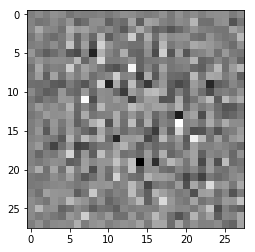

In [9]:
generator = make_generator_model()
noise = tf.random.normal([1, NZ])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             802816    
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### The Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(ND*1, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(ND*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00084578]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [20]:
fixed_z = tf.random.normal([EVAL_GEN_IMAGES, NZ])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NZ])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [22]:
def generate_and_save_images(generator, z):
    gen_images = generator(z, training=False)

    fig = plt.figure(figsize=(10,10))
    for i in range(gen_images.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
        # train batch
        losses_G = []
        losses_D = []
        for image_batch in dataset:
            loss_G, loss_D = train_step(image_batch)
            losses_G.append(loss_G)
            losses_D.append(loss_D)
        
        # eval
        if epoch % EVAL_INTERVAL is 0:
            # print log
            date_time = datetime.now(tz).strftime('%Y-%m-%d %H:%M:%S ')
            print('{} epoch={}; loss_G={:0.5}; loss_D={:0.5}'.\
                          format(date_time, epoch, np.average(losses_G), np.average(losses_D)))
            
            # save model
            checkpoint.save(file_prefix = os.path.join(checkpoint_dir, 'ckpt_epoch_{}'.format(epoch)))
            
            # generate fake images
            generate_and_save_images(generator, fixed_z)
            

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

2020-03-04 13:58:52  epoch=0; loss_G=0.55018; loss_D=1.1369


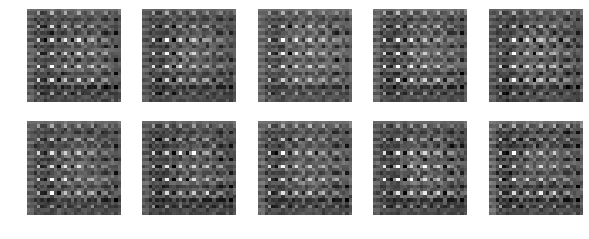

2020-03-04 13:59:21  epoch=100; loss_G=1.0431; loss_D=1.0825


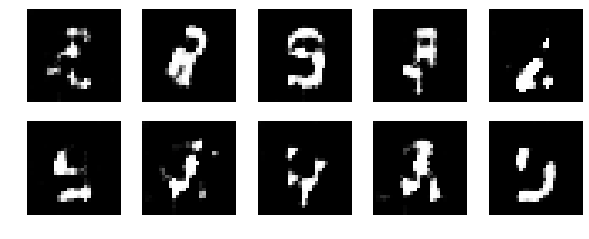

2020-03-04 13:59:50  epoch=200; loss_G=1.1477; loss_D=1.0956


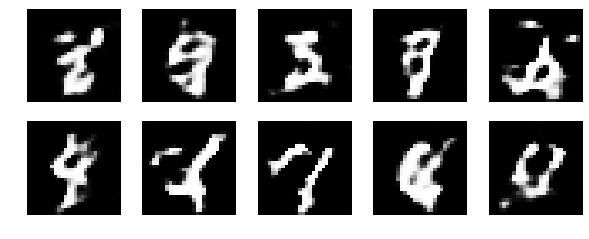

2020-03-04 14:00:18  epoch=300; loss_G=0.96403; loss_D=1.2041


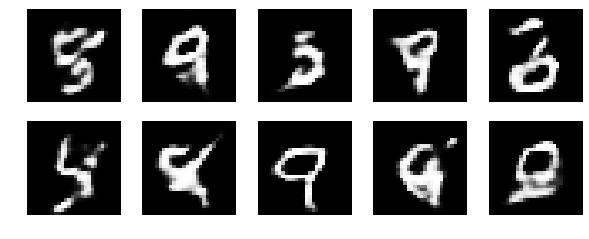

2020-03-04 14:00:47  epoch=400; loss_G=0.90586; loss_D=1.2623


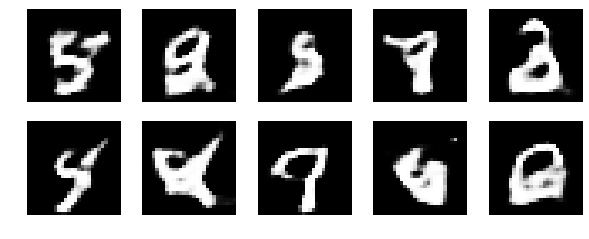

2020-03-04 14:01:16  epoch=500; loss_G=1.0715; loss_D=1.2759


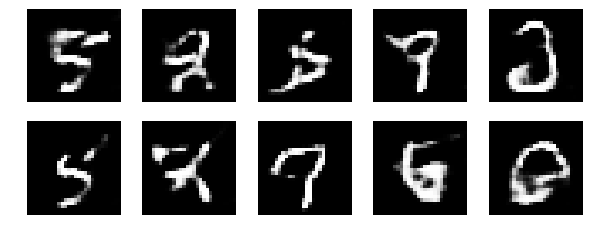

2020-03-04 14:01:45  epoch=600; loss_G=1.0018; loss_D=1.1576


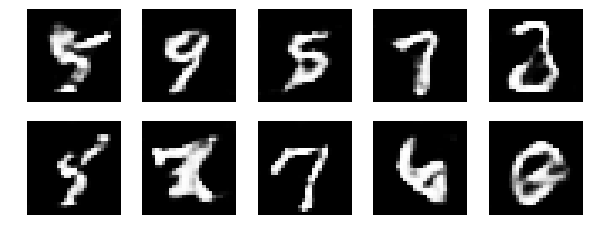

2020-03-04 14:02:14  epoch=700; loss_G=0.93665; loss_D=1.1958


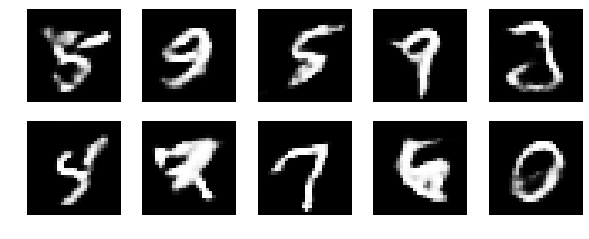

2020-03-04 14:02:43  epoch=800; loss_G=1.0064; loss_D=1.1837


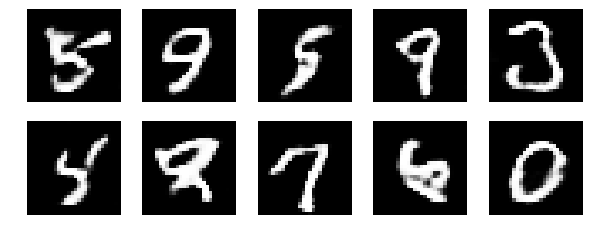

2020-03-04 14:03:12  epoch=900; loss_G=1.0406; loss_D=1.1991


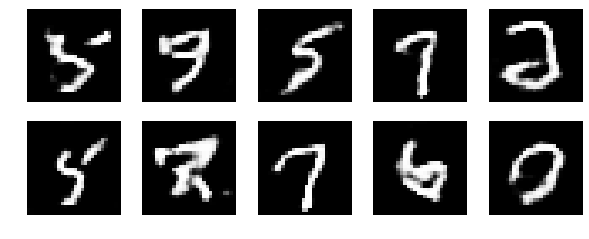

2020-03-04 14:03:40  epoch=1000; loss_G=0.94857; loss_D=1.1882


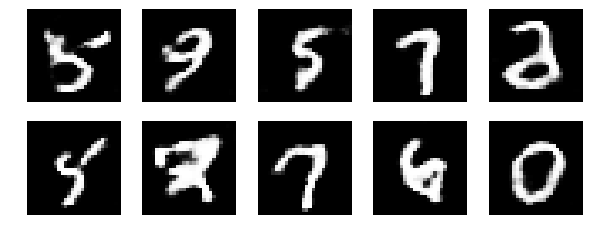

2020-03-04 14:04:09  epoch=1100; loss_G=0.97962; loss_D=1.1783


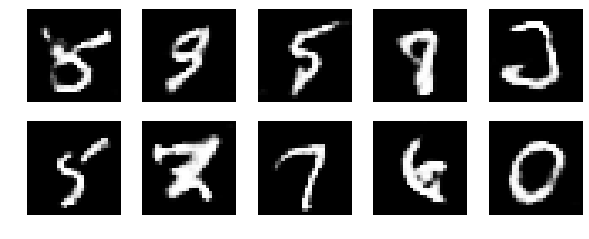

2020-03-04 14:04:38  epoch=1200; loss_G=1.0107; loss_D=1.1954


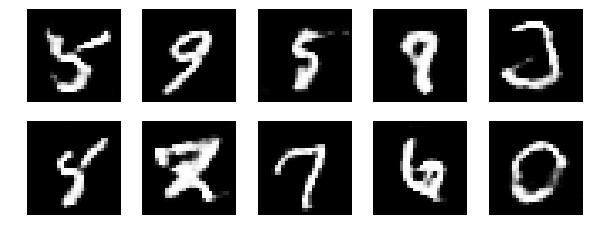

2020-03-04 14:05:07  epoch=1300; loss_G=1.0416; loss_D=1.1503


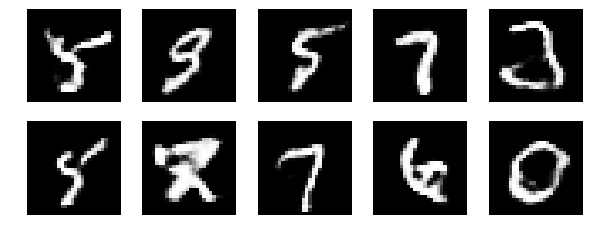

2020-03-04 14:05:36  epoch=1400; loss_G=1.0208; loss_D=1.164


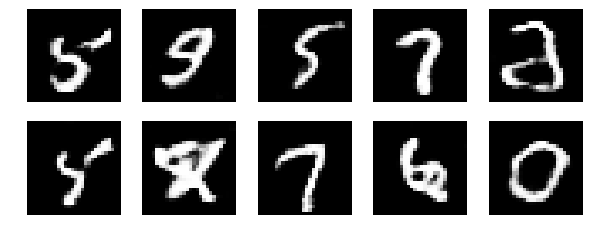

2020-03-04 14:06:05  epoch=1500; loss_G=1.0318; loss_D=1.1773


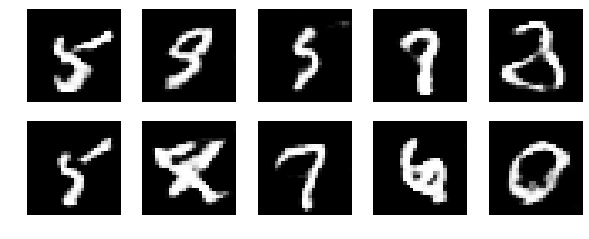

2020-03-04 14:06:34  epoch=1600; loss_G=1.0433; loss_D=1.1371


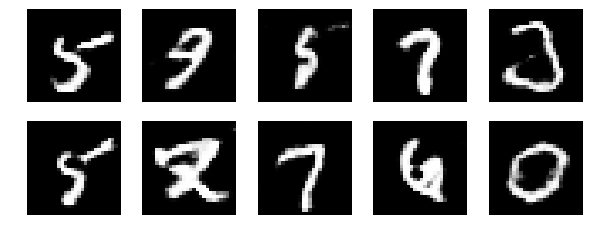

2020-03-04 14:07:02  epoch=1700; loss_G=1.0433; loss_D=1.1409


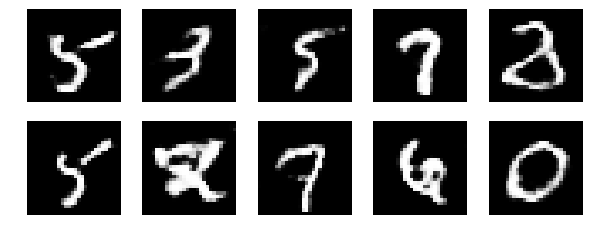

2020-03-04 14:07:31  epoch=1800; loss_G=1.0718; loss_D=1.1393


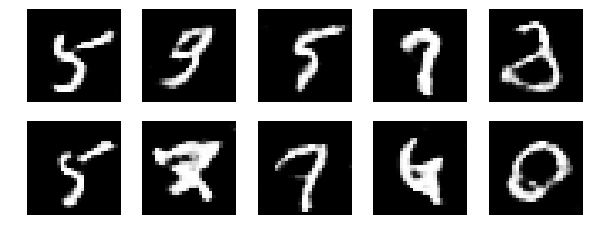

2020-03-04 14:08:00  epoch=1900; loss_G=1.0655; loss_D=1.1636


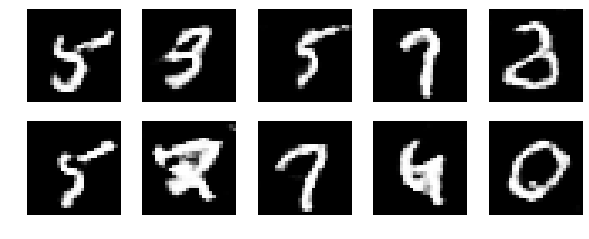

2020-03-04 14:08:29  epoch=2000; loss_G=1.0847; loss_D=1.1244


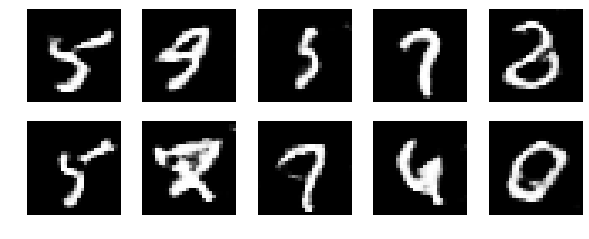

2020-03-04 14:08:57  epoch=2100; loss_G=1.097; loss_D=1.1313


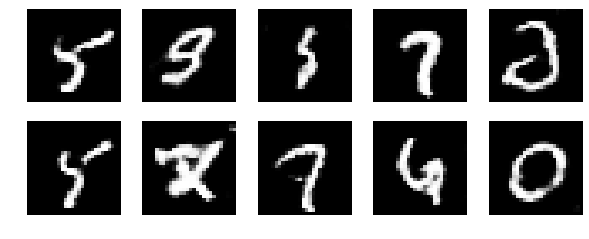

2020-03-04 14:09:26  epoch=2200; loss_G=1.0991; loss_D=1.1174


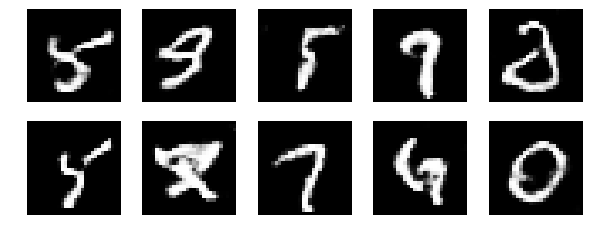

2020-03-04 14:09:55  epoch=2300; loss_G=1.1274; loss_D=1.089


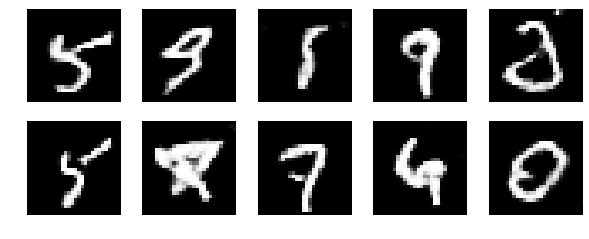

2020-03-04 14:10:24  epoch=2400; loss_G=1.1208; loss_D=1.125


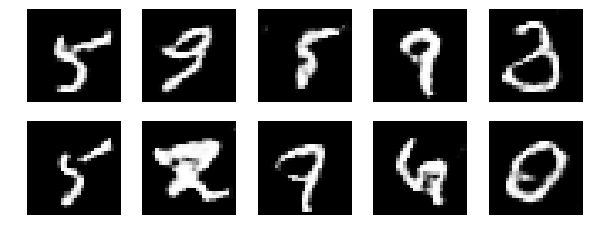

2020-03-04 14:10:53  epoch=2500; loss_G=1.1608; loss_D=1.0868


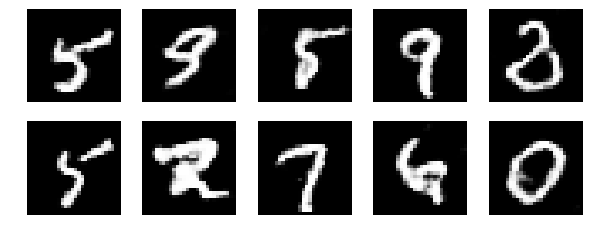

2020-03-04 14:11:22  epoch=2600; loss_G=1.1666; loss_D=1.0929


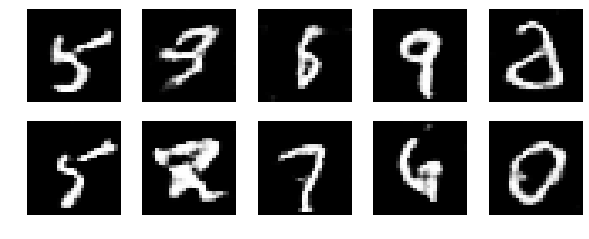

2020-03-04 14:11:51  epoch=2700; loss_G=1.2195; loss_D=1.0852


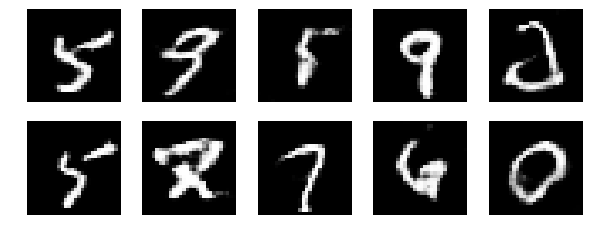

2020-03-04 14:12:20  epoch=2800; loss_G=1.1898; loss_D=1.0906


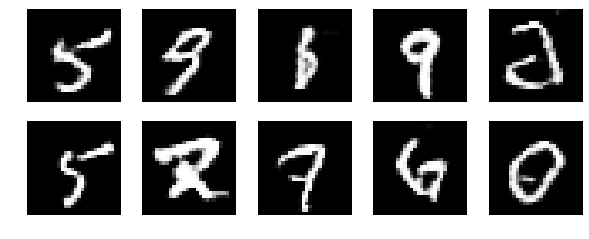

2020-03-04 14:12:49  epoch=2900; loss_G=1.2068; loss_D=1.0879


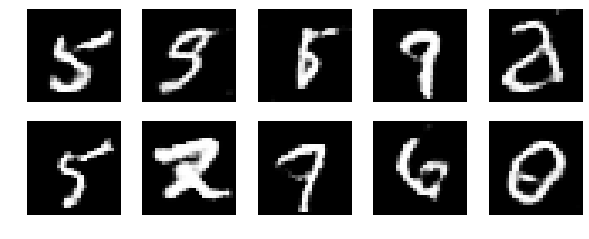

2020-03-04 14:13:18  epoch=3000; loss_G=1.2166; loss_D=1.0825


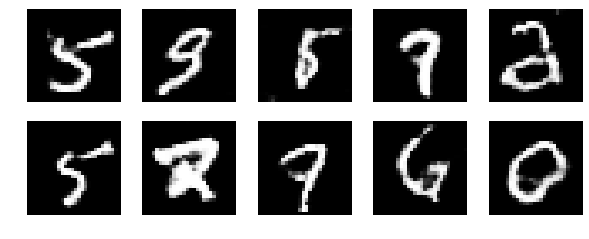

2020-03-04 14:13:47  epoch=3100; loss_G=1.2301; loss_D=1.0898


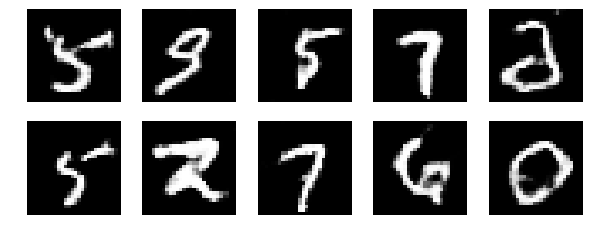

2020-03-04 14:14:16  epoch=3200; loss_G=1.1999; loss_D=1.0585


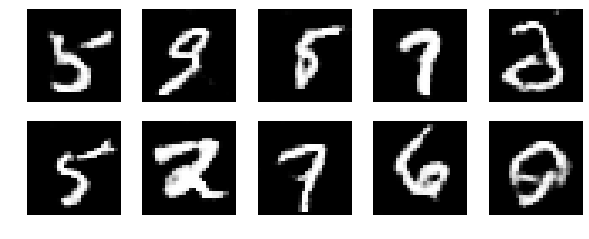

2020-03-04 14:14:45  epoch=3300; loss_G=1.2093; loss_D=1.0491


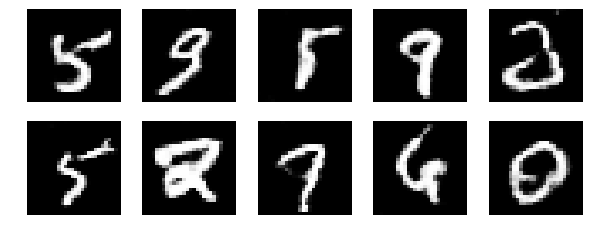

2020-03-04 14:15:14  epoch=3400; loss_G=1.2274; loss_D=1.0771


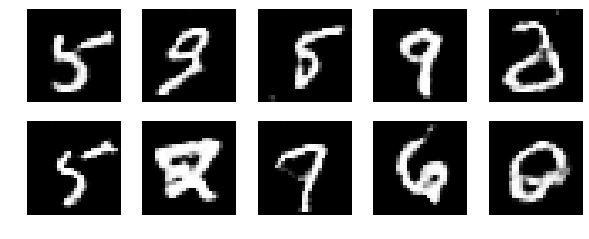

2020-03-04 14:15:42  epoch=3500; loss_G=1.241; loss_D=1.0604


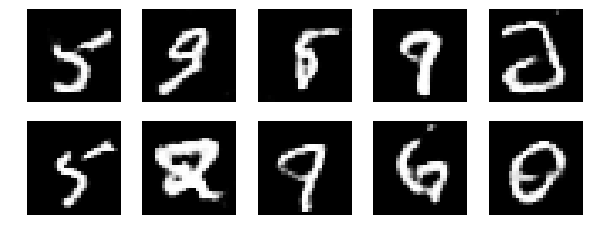

2020-03-04 14:16:11  epoch=3600; loss_G=1.2466; loss_D=1.0548


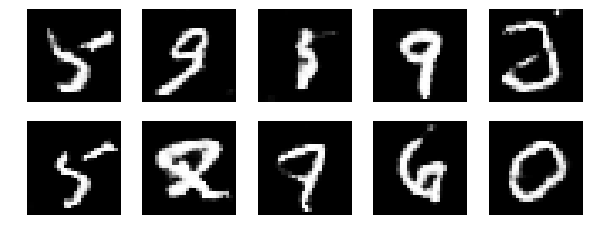

2020-03-04 14:16:40  epoch=3700; loss_G=1.2474; loss_D=1.0348


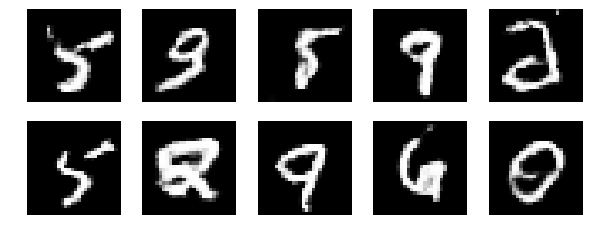

2020-03-04 14:17:09  epoch=3800; loss_G=1.2419; loss_D=1.0629


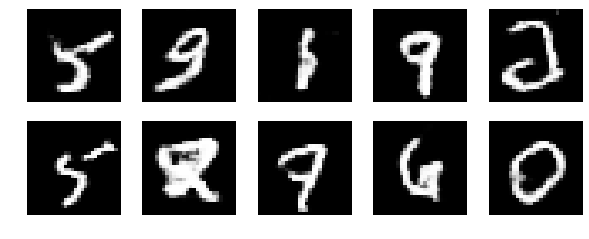

2020-03-04 14:17:38  epoch=3900; loss_G=1.2768; loss_D=1.0553


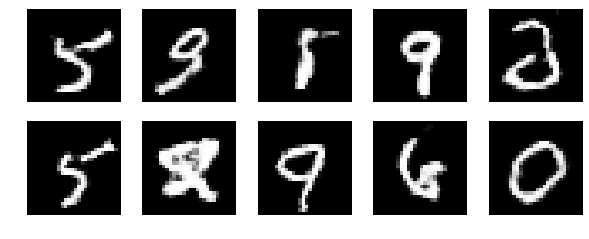

In [24]:
# train(train_dataset, EPOCHS)
train(train_dataset, 4000)